In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, AveragePooling2D,Flatten,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

In [3]:
categories=['without_mask','with_mask']
data=[]
labels=[]
for category in categories:
    for file in os.listdir(category):
        path=os.path.join(category,file)
        label=path.split(os.path.sep)[-2]
        img=load_img(path,target_size=(224,224))
        img=img_to_array(img)
        img=preprocess_input(img)
        data.append(img)
        labels.append(label)

In [4]:
x=np.array(data,dtype="float32")
y=np.array(labels)

In [5]:
lb=LabelBinarizer()
labels=lb.fit_transform(y)
labels=to_categorical(labels)
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [6]:
lb.classes_

array(['with_mask', 'without_mask'], dtype='<U12')

In [7]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,
                       width_shift_range=0.2,height_shift_range=0.2,
                       shear_range=0.15,horizontal_flip=True,vertical_flip=True)

In [8]:
X_train,X_test,y_train,y_test=train_test_split(x,labels,test_size=0.2,random_state=10,stratify=labels)

In [10]:
print(f"x _train_shape:{X_train.shape}")
print(f"X_test_shape:{X_test.shape}")
print(f"y_train_shape:{y_train.shape}")
print(f"y_test_shape:{y_test.shape}")


x _train_shape:(1100, 224, 224, 3)
X_test_shape:(276, 224, 224, 3)
y_train_shape:(1100, 2)
y_test_shape:(276, 2)


In [11]:
basemodel= MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input((224,224,3)))

In [12]:
basemodel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [13]:
for layer in basemodel.layers:
    layer.trainable=False

In [14]:
basemodel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [15]:
headmodel=basemodel.output
avgpooling= AveragePooling2D(pool_size=(7,7),name='avgpooling')(headmodel)
flatten= Flatten(name='Flatten')(avgpooling)
dense1= Dense(128,activation='relu')(flatten)
drop=Dropout(0.5)(dense1)
dense2=Dense(2,activation='softmax')(drop)
model=Model(inputs=basemodel.input,outputs=dense2)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [17]:
learning_rate=0.001
Epochs=20
BS=12

opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

h=model.fit(
    aug.flow(X_train,y_train,batch_size=BS),
    steps_per_epoch=len(X_train)//BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//BS,
    epochs=Epochs
)


Epoch 1/20


C:\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 14s 95ms/step - loss: 0.1916 - accuracy: 0.9311 - val_loss: 0.0539 - val_accuracy: 0.9819
Epoch 2/20
91/91 [==============================] - 8s 84ms/step - loss: 0.0596 - accuracy: 0.9835 - val_loss: 0.0528 - val_accuracy: 0.9783
Epoch 3/20
91/91 [==============================] - 8s 83ms/step - loss: 0.0453 - accuracy: 0.9853 - val_loss: 0.0433 - val_accuracy: 0.9855
Epoch 4/20
91/91 [==============================] - 8s 84ms/step - loss: 0.0513 - accuracy: 0.9853 - val_loss: 0.0400 - val_accuracy: 0.9819
Epoch 5/20
91/91 [==============================] - 8s 86ms/step - loss: 0.0338 - accuracy: 0.9881 - val_loss: 0.0478 - val_accuracy: 0.9746
Epoch 6/20
91/91 [==============================] - 8s 88ms/step - loss: 0.0299 - accuracy: 0.9890 - val_loss: 0.0439 - val_accuracy: 0.9855
Epoch 7/20
91/91 [==============================] - 8s 85ms/step - loss: 0.0449 - accuracy: 0.9871 - val_loss: 0.0500 - val_accuracy: 0.9819
Epoch 8/20
91/91 [=====

In [ ]:
model.save(mobile)

In [19]:
predict=model.predict(X_test,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(y_test.argmax(axis=1),predict,target_names=lb.classes_))

23/23 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       138
without_mask       0.99      0.98      0.98       138

    accuracy                           0.98       276
   macro avg       0.98      0.98      0.98       276
weighted avg       0.98      0.98      0.98       276



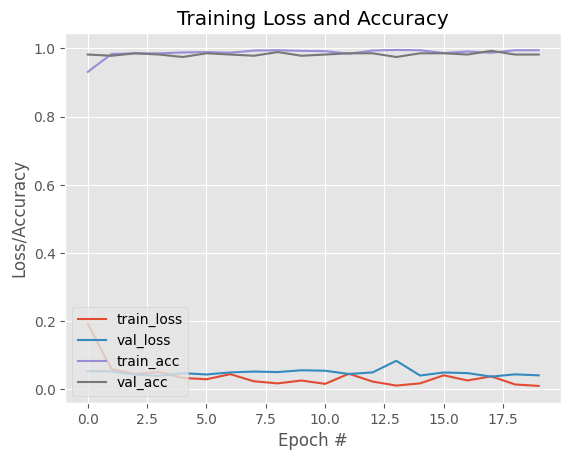

In [26]:

# plot the training loss and accuracy

N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot_v2.png')